In [1]:
from sklearn.datasets import fetch_20newsgroups
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.naive_bayes import MultinomialNB

In [27]:
import nltk 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# importing data from sklearn 
newsgroups=fetch_20newsgroups()
# stopwords:words not to be included in vocabulary
stops=set(stopwords.words('english'))
# removing punctuations
punctuations=list(string.punctuation)
# adding punctuations to stops itself
stops.update(punctuations)
additionalstops=np.loadtxt('stopwords.txt',dtype=str,delimiter=" ")
stops.update(additionalstops)
newsgroups.keys()


dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
len(stops)

824

In [5]:
# no of documents
len(newsgroups.data)

11314

In [6]:
# all_document:contains all X data
all_documents=newsgroups.data
# all_categories:contains all Y data
all_categories=newsgroups.target
# converting all_document to list of list of words(tokenized data for each element)
all_documents_modified=[word_tokenize(doc) for doc in all_documents]

In [7]:
#splitting these documents in train and test data.
x_train, x_test, y_train, y_test=train_test_split(all_documents_modified, all_categories, random_state=1)

In [8]:
# variable to store all words from all tokenized documents
all_words=[]
for doc in x_train:
    for word in doc:
        if(word.lower() not in stops) and len(word)!=1 and len(word)!=2 and word!="n't" and word[0]!=".":
            all_words.append(word)


In [9]:
len(all_words)

1308617

In [10]:
def Dict_freq(all_words):
    dic=dict()
#     iterating through all_words and incrementing frequency if word already present in dic else initialising frequency as 1
    for word in all_words:
        if word in dic.keys():
            dic[word]+=1
        else:
            dic[word]=1
    return dic
dic=Dict_freq(all_words)

In [11]:
# converting to numpy array to sort in descending order to get top k features
freq=np.array([i for i in dic.values()])
words=np.array([i for i in dic.keys()])
words=words[np.argsort(freq)][::-1]
freq=np.sort(freq)[::-1]

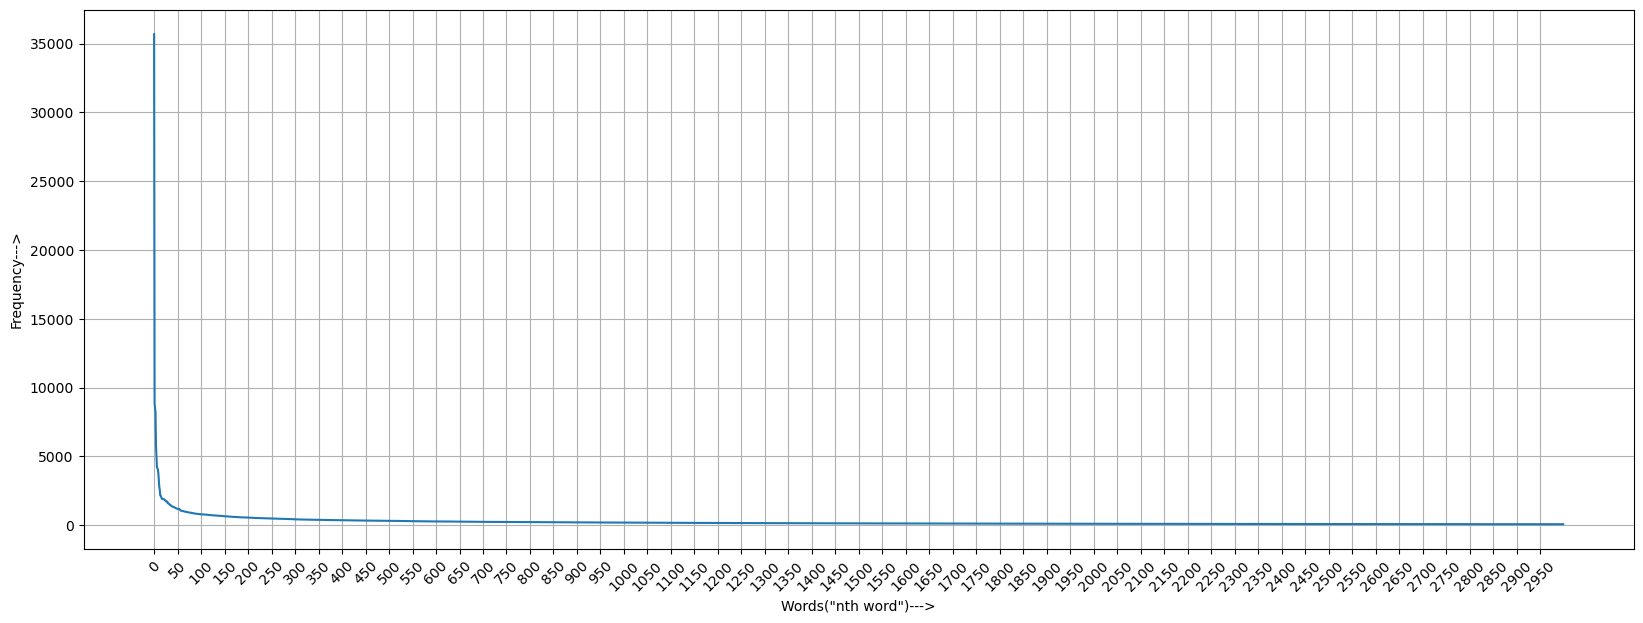

In [12]:
# visualising frequncy trend to analyse our data
import matplotlib.pyplot as plt
lower_limit=0
upper_limit=3000
difference_between_each_xtick=50
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(freq))[lower_limit:upper_limit], freq[lower_limit:upper_limit])
#labelling
plt.xlabel('Words("nth word")--->')
plt.ylabel("Frequency--->")
#adjusting the xticks
plt.xticks(np.arange(lower_limit, upper_limit, 50), rotation=45)
plt.grid()
plt.show()

In [13]:
features=words[20:100000]
# restricting our freq variable to limit words which are most frequent in all document
# as they may be present in all documents which will skew our data
# limiting data between freq[20] and freq[9999]
freq[20], freq[10000]

(1888, 17)

In [14]:
# creating a 2D array with documents as rows and columns are features,the particular cell contains the frequency of that particular document and feature.
# the params taken by function are x_train or x_test and the list of all features
def data_initialisor(x_data,features):
    modified_data=np.zeros((len(x_data), len(features)))
    max_count=len(x_data)
    for i in range(len(x_data)):
        current_doc=x_data[i]
        d=dict()
        for word in current_doc:
            if word in d.keys():
                d[word]+=1
            else:
                d[word]=1
        for j in range (len(features)):
            if features[j] in d.keys():
                modified_data[i][j]=d[features[j]]
            else:
                continue
    return modified_data

In [24]:
#training and testing data has to be modified saparately because we cant use the testing data for training purpose
#as both the Training and testing data must be having their own separate vocabularies.

In [15]:
x_train_modified=data_initialisor(x_train,features)

In [18]:
x_test_modified=data_initialisor(x_test,features)

## Using inbuilt Multinomial Naive Bayes classifier

In [19]:
clf=MultinomialNB()
clf.fit(x_train_modified,y_train)
clf.score(x_test_modified,y_test)

0.8868858253799929

## Engineering self Naive Bayes Classifier

In [20]:
def fit(x_train,y_train):
    count=dict()
    for i in range(20):
        needed_docs=x_train[y_train==i]
        count[i]=dict()
#         to maintain total number of words in class i
        count[i]['total']=0
        for j in range(len(features)):
#             no. of time jth feature is occuring corresponding to class i
            count[i][features[j]]=needed_docs[:,j].sum()
#   
            count[i]['total']+=count[i][features[j]]
    return count
# The probablity function takes the dictionary,current data point and current class
def probablity(dictionary,x,current_class):
    prob_for_each_word=[]
    for i in range(len(x)):
#         omitting features whose values corresponding to current doc is 0,i.e not present
        if x[i]!=0:
#         denotes number of occurences of ith feature in current class
            num=dictionary[current_class][features[i]]
#             total words in current class
            den=dictionary[current_class]['total']
#     taking logarithmic probablity to avoid multiplication of small probablitites amounting to 0, i.e laplace correction 
            prob=np.log((num+1)/(den+len(x)))
            prob_for_each_word.append(prob)
    return sum(prob_for_each_word)
def predictSinglePoint(dictionary,x):
    classes=dictionary.keys()
    best_p=-1000
    best_class=-1
    #initiated best_p and best_class variables with negative values because we want to consider maximum valued probabilities at
    #the end. In the first run itself they will be replaced by positive values. "best_p" variable denotes the best probability
    #uptill now. and as the name suggests, best_class denotes the best possible class uptill now.
    first_run=True
    for current_class in classes:
#         probablity of current class
        p_current_class=probablity(dictionary,x,current_class)
        if(first_run or p_current_class>best_p):
            best_p=p_current_class
            best_class=current_class
        first_run=False
    return best_class
def predict(x_test,dictionary):
    y_pred=[]
    #y_pred maintains all the predicted classes for provided testing data.
    for doc in x_test:
        y_pred.append(predictSinglePoint(dictionary,doc))
    return y_pred
    
    
            


In [21]:
# calling the fit function for the data
dictionary=fit(x_train_modified, y_train)

In [22]:
# getting predicted y values
y_pred=predict(x_test_modified, dictionary)

In [23]:
# printing confusion and classification matrix 
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.91      0.90      0.91       114
           1       0.82      0.81      0.81       152
           2       0.97      0.63      0.77       139
           3       0.76      0.80      0.78       152
           4       0.88      0.89      0.89       138
           5       0.74      0.96      0.84       153
           6       0.89      0.63      0.74       147
           7       0.94      0.88      0.91       137
           8       0.98      0.95      0.97       131
           9       0.96      0.95      0.96       135
          10       0.95      0.98      0.96       136
          11       0.82      1.00      0.90       145
          12       0.89      0.81      0.85       157
          13       0.97      0.97      0.97       151
          14       0.93      0.95      0.94       155
          15       0.84      0.96      0.89       159
          16       0.85      0.97      0.91       140
          17       0.89    

# Conclusion
Comparing the accuracy in both the cases i.e inbuilt multinomial and our own naive bayes algorithm,the accuracy comes out to be nearly equal nearly 86% .We can achieve a better accuracy by working on selection features,the accuracy can be upto 90% max by increasing the number of features in the 13th cell to 50,000.We also observe that increasing the number of features will decrease the accuracy.